<h1><center><font size="6">Flutter Notebook</font></center></h1>

# Contents

- <a href='#1'>Importing Packages</a>  
- <a href='#2'>Generating Datasets</a>
- <a href='#3'>Creating Labels File</a>
- <a href='#4'>Creating Tensorfllow Lite Model</a>
    - <a href='#41'>Generating the Datasets</a> 
    - <a href='#42'>Constructing and Compiling the Model</a> 
    - <a href='#43'>Defining Callbacks</a>
    - <a href='#44'>Training the Model</a>     
    - <a href='#45'>Evaluating the Model</a> 
    - <a href='#46'>Predicting on Holdout Set</a>
    - <a href='#47'>Confusion Matrix</a> 
    - <a href='#48'>Saving the Model</a> 
   

# Importing Packages

In [2]:
# importing packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime

import warnings
warnings.simplefilter("ignore")

import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPool2D, GlobalAveragePooling2D, Input
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, CSVLogger, ReduceLROnPlateau
from keras.applications import MobileNetV2

%reload_ext autoreload
%autoreload 2
from utils import *

# Generating Datasets

In [10]:
# create datasets for training, validation, and testing
train_fldr = '../sample/train'
val_fldr = '../sample/val'
test_fldr = '../sample/test'
test_fldr_2 = '../split/test2'

train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_fldr,
        target_size = (224, 224),
        batch_size = 16,
        class_mode = 'binary',
        seed = 42)
valid_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_fldr, 
        target_size = (224, 224),
        batch_size = 16,
        class_mode = 'binary',
        seed = 42)
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_fldr, 
        target_size = (224, 224),
        batch_size = 1,
        class_mode = 'binary',
        shuffle = False,
        seed = 42)
test_generator_2 = ImageDataGenerator(rescale=1/255).flow_from_directory(
        test_fldr_2,
        target_size = (224, 224),
        batch_size = 1,
        class_mode = 'binary',
        shuffle = False,
        seed = 42)

STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size
STEP_SIZE_TEST = test_generator.n // test_generator.batch_size
STEP_SIZE_TEST_2 = test_generator_2.n // test_generator_2.batch_size

Found 6840 images belonging to 2 classes.
Found 753 images belonging to 2 classes.
Found 753 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


# Creating labels file

In [3]:
# create labels.txt file that will hold all our labels for Flutter
print(train_generator.class_indices) 
labels = '\n'.join(sorted(train_generator.class_indices.keys())) 
with open('labels.txt', 'w') as f: 
    f.write(labels)


{'mel': 0, 'not_mel': 1}


# Creating Tensorflow Lite Model

## Constructing the Model

In [4]:
# create base model for transfer learning
base_model = MobileNetV2(
    input_shape = (224, 224, 3),
    include_top = False, 
    weights = 'imagenet'
)

In [5]:
# freezes all neurons for base model
base_model.trainable = False 
# construct model
model = Sequential([ 
    base_model,
    Conv2D(32, 3, activation = 'relu'), 
    Dropout(0.2), 
    GlobalAveragePooling2D(), 
    Dense(1, activation = 'sigmoid')
])

## Compiling the Model

In [11]:
# compile model
model.compile(
    optimizer = tf.keras.optimizers.Adam(lr = 0.001),
    loss = 'binary_crossentropy', 
    metrics = ['accuracy', keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.AUC(), keras.metrics.AUC(curve='PR')])

## Defining the Callbacks

In [14]:
# Define callbacks
lr_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                 patience = 3,
                                 verbose = 1,
                                 factor = 0.5,
                                 min_lr = 0.00001)
filepath = "../logs/log_mobilenet/model.{epoch:02d}-{val_loss:.2f}.hdf5"
mcp_save = ModelCheckpoint(filepath, 
                           verbose = 1, 
                           monitor = 'val_loss', 
                           mode = 'min')
csv_logger = CSVLogger('../logs/log_mobilenet/log.csv')
log_dir = "../logs/log_mobilenet/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_cb = TensorBoard(log_dir = log_dir,
                             histogram_freq = 1,
                             update_freq = 'batch')

## Training the Model

In [15]:
# train model
history = model.fit_generator(generator = train_generator,
                             steps_per_epoch = STEP_SIZE_TRAIN,
                             validation_data = valid_generator,
                             validation_steps = STEP_SIZE_VALID,
                             epochs = 20,
                             callbacks = [lr_reduction, mcp_save, tensorboard_cb, csv_logger])

/Users/examsherpa/opt/anaconda3/envs/nn-env/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
Epoch 1/20
427/427 [==============================] - 1421s 3s/step - loss: 0.2356 - accuracy: 0.9220 - precision: 0.9260 - recall: 0.9753 - auc: 0.9412 - auc_1: 0.9699 - val_loss: 0.1479 - val_accuracy: 0.9495 - val_precision: 0.9500 - val_recall: 0.9938 - val_auc: 0.9581 - val_auc_1: 0.9925

Epoch 00001: saving model to ../logs/log_mobilenet/model.01-0.15.hdf5
Epoch 2/20
427/427 [==============================] - 1574s 4s/step - loss: 0.1251 - accuracy: 0.9556 - precision: 0.9553 - recall: 0.9878 - auc: 0.9795 - auc_1: 0.9909 - val_loss: 0.1525 - val_accuracy: 0.9441 - val_precision: 0.9663 - val_recall: 0.9692 - val_auc: 0.9575 - val_auc_1: 0.9923

Epoch 00002: saving

## Evaluating the Model

In [20]:
# create dataframe of training metrics
history = pd.read_csv("../logs/log_mobilenet/log.csv")
history

,epoch,accuracy,auc,auc_1,loss,lr,precision,recall,val_accuracy,val_auc,val_auc_1,val_loss,val_precision,val_recall
0,0,0.937134,0.964155,0.982928,0.177265,0.001000,0.938040,0.982287,0.949468,0.958054,0.992547,0.147887,0.950000,0.993846
1,1,0.957943,0.980760,0.991104,0.120084,0.001000,0.958341,0.987678,0.944149,0.957541,0.992319,0.152525,0.966258,0.969231
2,2,0.965563,0.986931,0.994155,0.099192,0.001000,0.964942,0.990760,0.948138,0.938997,0.982792,0.153424,0.963636,0.976959
3,3,0.968494,0.989859,0.995423,0.084597,0.001000,0.967675,0.991718,0.949468,0.958401,0.990816,0.144011,0.965046,0.976923
4,4,0.978019,0.995032,0.997830,0.061098,0.000500,0.975835,0.995762,0.964096,0.941810,0.983465,0.147830,0.965620,0.993846
5,5,0.980803,0.996239,0.998491,0.054188,0.000500,0.979731,0.995381,0.944149,0.954487,0.989371,0.152407,0.969136,0.966154
6,6,0.982122,0.997895,0.999315,0.046148,0.000500,0.980496,0.996344,0.965426,0.935830,0.981636,0.156686,0.968468,0.992308
7,7,0.985492,0.997811,0.999153,0.041379,0.000500,0.983118,0.998074,0.952128,0.937677,0.983090,0.175646,0.970859,0.973846
8,8,0.986958,0.998437,0.999372,0.036882,0.000500,0.985546,0.997498,0.957447,0.918914,0.975808,0.229965,0.961194,0.990769
9,9,0.986225,0.999223,0.999752,0.031986,0.000500,0.984779,0.997303,0.960106,0.927781,0.978777,0.182636,0.968326,0.986175


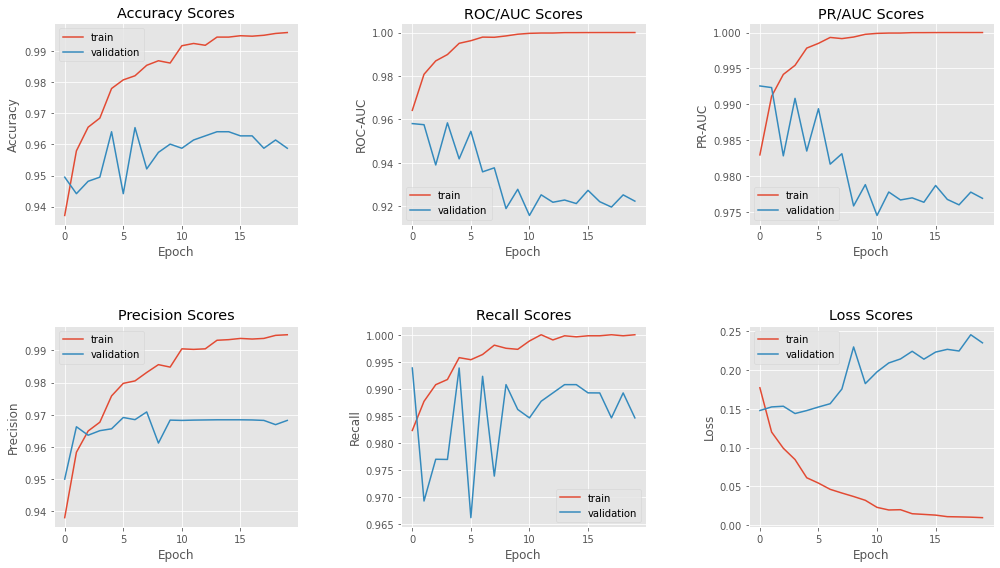

In [23]:
# create visualizations of training metrics
plt.style.use("ggplot")
sixplot2(history, "auc", "val_auc", "auc_1", "val_auc_1", "precision", "val_precision", "recall", "val_recall")

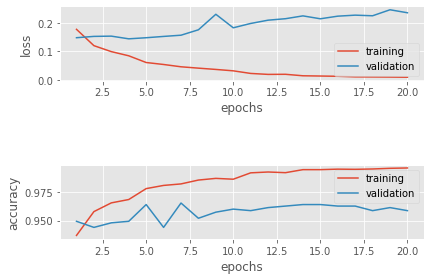

In [27]:
# visualization for loss and accuracy
train_val_metrics2(20, history)

## Saving Whole Model and Loading Best Model

In [23]:
# save entire model
model.save('../models/mobilenet')

INFO:tensorflow:Assets written to: ../models/mobilenet/assets


In [4]:
# load entire model after training proccess
model = load_model('../models/mobilenet')

In [5]:
# load model with lowest validation loss
model2 = load_model('../logs/log_mobilenet/model.04-0.14.hdf5')

## Predicting on Holdout Set

753/753 [==============================] - 329s 436ms/step


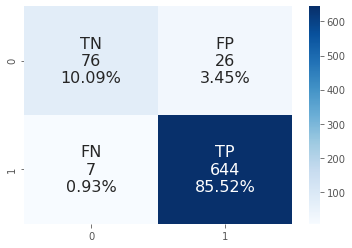

In [12]:
# display confusion matrix visualization
test_generator.reset()
pred = model.predict_generator(test_generator, steps = STEP_SIZE_TEST, verbose = 1)
y_true = test_generator.classes
y_pred = pred > 0.5
make_confusion_matrix(y_true, y_pred)

In [15]:
# get testing accuracy and loss
test_generator.reset()
score = model.evaluate_generator(test_generator, verbose = 1)

print("Loss: " + str(score[0]))
print("Accuracy: " + str(score[1]))
print("Precision: " + str(score[2]))
print("Recall: " + str(score[3]))
print("ROC-AUC: " + str(score[4]))
print("PR-AUC: " + str(score[5]))

753/753 [==============================] - 161s 208ms/step - loss: 0.2221 - accuracy: 0.9562 - precision: 0.9612 - recall: 0.9892 - auc: 0.9247 - auc_1: 0.9779
Loss: 0.22214962542057037
Accuracy: 0.9561753273010254
Precision: 0.9611940383911133
Recall: 0.9892473220825195
ROC-AUC: 0.9247462749481201
PR-AUC: 0.9779129028320312


## Predicting on Holdout Set with Lowest Validation Loss Model

753/753 [==============================] - 152s 201ms/step


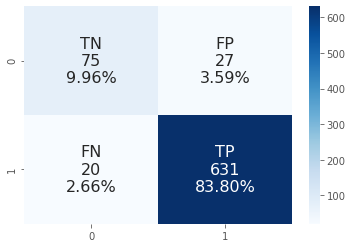

In [17]:
# display confusion matrix visualization
test_generator.reset()
pred2 = model2.predict_generator(test_generator, steps = STEP_SIZE_TEST, verbose = 1)
y_true = test_generator.classes
y_pred2 = pred2 > 0.5
make_confusion_matrix(y_true, y_pred2)

In [18]:
# get testing accuracy and loss
test_generator.reset()
score2 = model2.evaluate_generator(test_generator, verbose = 1)

print("Loss: " + str(score2[0]))
print("Accuracy: " + str(score2[1]))
print("Precision: " + str(score2[2]))
print("Recall: " + str(score2[3]))
print("ROC-AUC: " + str(score2[4]))
print("PR-AUC: " + str(score2[5]))

753/753 [==============================] - 144s 190ms/step - loss: 0.1825 - accuracy: 0.9376 - precision: 0.9590 - recall: 0.9693 - auc: 0.9380 - auc_1: 0.9845
Loss: 0.1825425624847412
Accuracy: 0.9375830292701721
Precision: 0.9589665532112122
Recall: 0.9692780375480652
ROC-AUC: 0.9379837512969971
PR-AUC: 0.9845151305198669


## Predicting on Additional Holdout Set

2000/2000 [==============================] - 356s 178ms/step


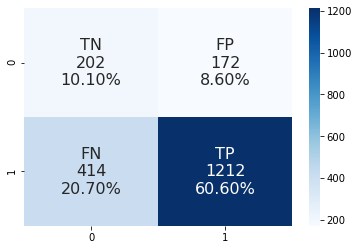

In [6]:
# display confusion matrix visualization
test_generator_2.reset()
pred_2 = model.predict_generator(test_generator_2, steps = STEP_SIZE_TEST_2, verbose = 1)
y_true = test_generator_2.classes
y_pred_2 = pred_2 > 0.5
make_confusion_matrix(y_true, y_pred_2)

In [7]:
# get testing accuracy and loss
test_generator_2.reset()
score3 = model.evaluate_generator(test_generator_2, verbose = 1)

print("Loss: " + str(score3[0]))
print("Accuracy: " + str(score3[1]))
print("Precision: " + str(score3[2]))
print("Recall: " + str(score3[3]))
print("ROC-AUC: " + str(score3[4]))
print("PR-AUC: " + str(score3[5]))

2000/2000 [==============================] - 365s 182ms/step - loss: 1.4713 - accuracy: 0.7070 - precision: 0.8757 - recall: 0.7454 - auc: 0.6854 - auc_1: 0.8885
Loss: 1.4712997674942017
Accuracy: 0.7070000171661377
Precision: 0.8757225275039673
Recall: 0.7453874349594116
ROC-AUC: 0.6854128241539001
PR-AUC: 0.8885043859481812


## Predicting on Additional Holdout Set with Lowest Validation Loss Model

2000/2000 [==============================] - 387s 193ms/step


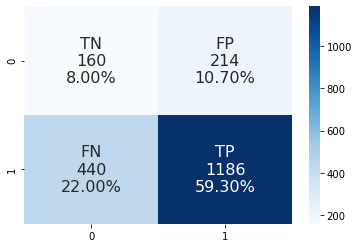

In [11]:
# display confusion matrix visualization
test_generator_2.reset()
pred_2a = model2.predict_generator(test_generator_2, steps = STEP_SIZE_TEST_2, verbose = 1)
y_true = test_generator_2.classes
y_pred_2a = pred_2a > 0.5
make_confusion_matrix(y_true, y_pred_2a)

In [12]:
# get testing accuracy and loss
test_generator_2.reset()
score4 = model2.evaluate_generator(test_generator_2, verbose = 1)

print("Loss: " + str(score4[0]))
print("Accuracy: " + str(score4[1]))
print("Precision: " + str(score4[2]))
print("Recall: " + str(score4[3]))
print("ROC-AUC: " + str(score4[4]))
print("PR-AUC: " + str(score4[5]))

2000/2000 [==============================] - 365s 182ms/step - loss: 0.9258 - accuracy: 0.6730 - precision: 0.8471 - recall: 0.7294 - auc: 0.6232 - auc_1: 0.8664
Loss: 0.9257777333259583
Accuracy: 0.6729999780654907
Precision: 0.8471428751945496
Recall: 0.7293972969055176
ROC-AUC: 0.6232289671897888
PR-AUC: 0.8663884997367859


## Save and Convert Best Model to TensorLite Flow

In [19]:
saved_model_dir = '../models/tensorlite' 
tf.saved_model.save(model, saved_model_dir) 

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir) 
tflite_model = converter.convert()

with open('../models/model.tflite', 'wb') as f: 
  f.write(tflite_model)

INFO:tensorflow:Assets written to: ../models/tensorlite/assets
